In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Inspector creation 
inspector = inspect(engine)
# Collect the name of the columns for measuremnt table
measu_columns = inspector.get_columns('Measurement')
print("The columns for the table Measuremnt are: ")
for column in measu_columns:
    print(column["name"], column["type"])
print("------------------------------------------")

# Collect the name of the columns for station table
station_columns = inspector.get_columns('station')
print("The columns for the table Station are: ")
for column in station_columns:
    print(column["name"], column["type"])
print("------------------------------------------")

The columns for the table Measuremnt are: 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------------------------------------
The columns for the table Station are: 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
------------------------------------------


The lastest date in the database is: 2017-08-23


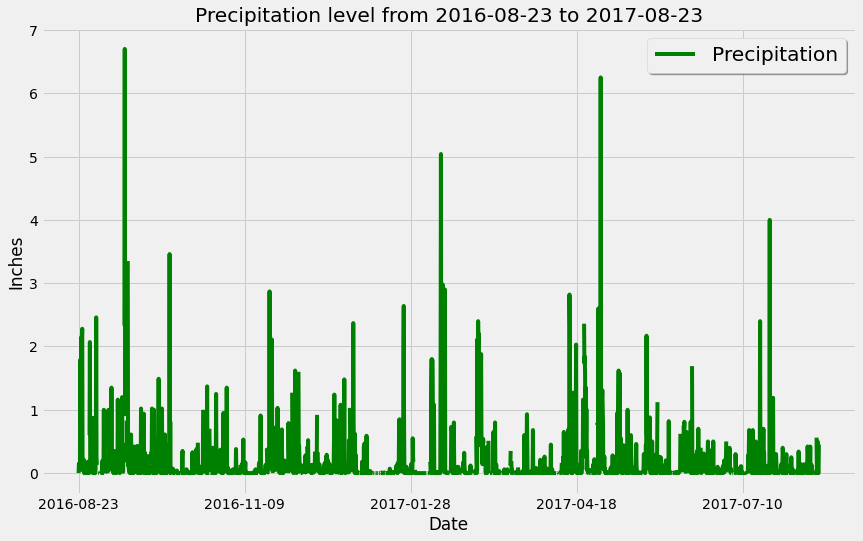

In [188]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date[0],'%Y-%m-%d').date()
print(f"The lastest date in the database is: {latest_date}")

# Calculate the date 1 year ago from the last data point in the database
last_12_months_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_prcp = session.query(Measurement.date, Measurement.prcp).\
               filter(Measurement.date >= last_12_months_date ).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_prcp_df = pd.DataFrame(last_12_prcp)
# Sort the dataframe by date
last_12_prcp_df = last_12_prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

ax = last_12_prcp_df.plot('date','prcp',figsize = [13,8], title = f"Precipitation level from {last_12_months_date} to {latest_date}",
                    legend = True, color = 'green')
ax.set_xlabel("Date")
ax.set_ylabel('Inches')
ax.legend(labels=['Precipitation'],loc='upper right', shadow=True, fontsize='x-large')
fig = ax.get_figure()
fig.savefig('figures/precipitation_figure.png')


In [95]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#Statistics per date
Summary_Table = pd.DataFrame()
Summary_Table["Mean"] = last_12_prcp_df.groupby(['date'])["prcp"].mean()
Summary_Table["Median"] = last_12_prcp_df.groupby(['date'])["prcp"].median()
Summary_Table["Variance"] = last_12_prcp_df.groupby(['date'])["prcp"].var()
Summary_Table["Standard Deviation"] = last_12_prcp_df.groupby(['date'])["prcp"].std()
Summary_Table["Standard Error of the Mean (SEM) "] = last_12_prcp_df.groupby(['date'])["prcp"].sem()
Summary_Table

,Mean,Median,Variance,Standard Deviation,Standard Error of the Mean (SEM)
date,,,,,
2016-08-23,0.451667,0.100,0.499097,0.706468,0.288414
2016-08-24,1.555000,1.800,0.706510,0.840541,0.343150
2016-08-25,0.077143,0.080,0.005157,0.071813,0.027143
2016-08-26,0.016667,0.015,0.000267,0.016330,0.006667
2016-08-27,0.064000,0.020,0.006680,0.081731,0.036551
...,...,...,...,...,...
2017-08-19,0.030000,0.000,0.002700,0.051962,0.030000
2017-08-20,0.005000,0.005,0.000050,0.007071,0.005000
2017-08-21,0.193333,0.020,0.100933,0.317700,0.183424


In [96]:
#General statistics in the whole year 
summary_year = pd.DataFrame()
summary_year = last_12_prcp_df.describe()
summary_year

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [120]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Measurement.station.distinct())).scalar()
print(f'The number of stations is: {num_stations}')

The number of stations is: 9


In [142]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
number_per_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

# As the values are organized in descending order, the first element in the list is the station with 
# the biggest number of repetitions 
max_station_num = number_per_station[0][1]
max_station_name = number_per_station[0][0]

for item in number_per_station:
    print(f'The station {item[0]} has {item[1]} repetitions')
    print('----------------------------------------------')        
print('\n')
print(f'The most active station is: {max_station_name} with {max_station} appearances')

The station USC00519281 has 2772 repetitions
----------------------------------------------
The station USC00519397 has 2724 repetitions
----------------------------------------------
The station USC00513117 has 2709 repetitions
----------------------------------------------
The station USC00519523 has 2669 repetitions
----------------------------------------------
The station USC00516128 has 2612 repetitions
----------------------------------------------
The station USC00514830 has 2202 repetitions
----------------------------------------------
The station USC00511918 has 1979 repetitions
----------------------------------------------
The station USC00517948 has 1372 repetitions
----------------------------------------------
The station USC00518838 has 511 repetitions
----------------------------------------------


The most active station is: USC00519281 with 2772 appearances


In [170]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temperature = session.query(Measurement.date,Measurement.tobs).\
               filter(Measurement.station == max_station_name).all()

min_temperature = session.query(func.min(Measurement.tobs)).\
               filter(Measurement.station == max_station_name).scalar()
max_temperature = session.query(func.max(Measurement.tobs)).\
               filter(Measurement.station == max_station_name).scalar()
average_temperature = round(session.query(func.avg(Measurement.tobs)).\
               filter(Measurement.station == max_station_name).scalar(),2)
print(f'The lowest temperature in the {max_station_name} is {min_temperature}')
print(f'The highest temperature in the {max_station_name} is {max_temperature}')
print(f'The average temperature in the {max_station_name} is {average_temperature}')

The lowest temperature in the USC00519281 is 54.0
The highest temperature in the USC00519281 is 85.0
The average temperature in the USC00519281 is 71.66


,Number of repetitions
tobs,
54.0,1
56.0,4
57.0,6
58.0,6
59.0,5
60.0,15
61.0,19
62.0,37
63.0,33


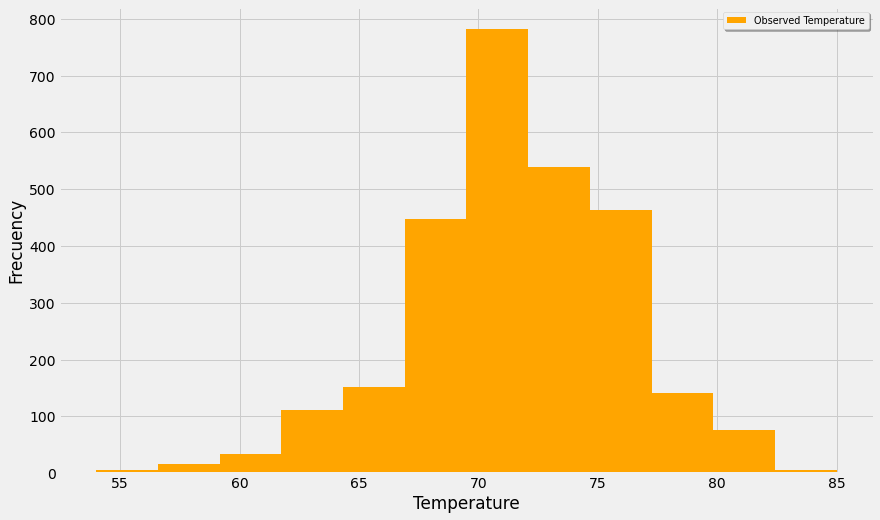

In [189]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Creating DataFrame with the temperature values
station_temp_df = pd.DataFrame(station_temperature)

# Analizing number of repetitions per temperature
temp_repetitions = pd.DataFrame(station_temp_df.groupby(['tobs'])["tobs"].count())
temp_repetitions = temp_repetitions.rename(columns= {'tobs': 'Number of repetitions'})

#Plotting
ax = station_temp_df.plot.hist('tobs',bins =12, figsize = [13,8], title = "Temperature repetitions"
                    legend = True, color = 'orange')
ax.set_xlabel("Temperature")
ax.set_ylabel('Frecuency')
ax.legend(labels=['Observed Temperature'],loc='upper right', shadow=True, fontsize='x-small')
fig = ax.get_figure()
fig.savefig('figures/histogram_temp.png')
temp_repetitions

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
